In [1]:
import json
import os
import re
from datetime import datetime, timedelta
from urllib.parse import urlparse
import time
import yaml

import bs4
from bs4 import BeautifulSoup
import requests

import dotenv

import IPython
from IPython.display import HTML, Markdown, display

from atproto import Client

import PIL
from PIL import Image

print(f"requests        {requests.__version__}")
print(f"BeautifulSoup   {bs4.__version__}")

requests        2.31.0
BeautifulSoup   4.12.3


In [2]:
dotenv.load_dotenv()


True

# Load posts from BlueSky and format for Substack or a blog post
for now I share the interesting stuff on bluesky and then use this code to grab latest BlueSky 'tweets' and format a [Substack post](https://skynetandchill.com)


In [3]:
client = Client(base_url='https://bsky.social')
client.login(os.environ['BSKY_USERNAME'], os.environ['BSKY_SECRET'])

mydid = {"did":"did:plc:qomkdnxrqw3gkbytdxea5z65"}

data = client.get_author_feed(
    actor=mydid['did'],
    filter='posts_and_author_threads',
    limit=50,
)


In [4]:
def remove_urls(text):
    # Regular expression to match URLs
    url_pattern = r'https?://\S+|www\.\S+'
    # Substitute found URLs with an empty string
    clean_text = re.sub(url_pattern, '', text)
    return clean_text


In [5]:
def rawfetchurl(url, timeout=60):
    """get url using requests with specified timeout. return response object, status, content-type"""
    try:
        response = requests.get(url, timeout=timeout)
    except httplib.BadStatusLine:
        log("Bad response (?) fetching url %s " % url)
        response = None
    except requests.Timeout:
        log("Timeout fetching url %s " % url)
        response = None
    except requests.ConnectionError as e:
        log("Connection error (%s) fetching url %s " % (str(e), url))
        response = None
    except requests.TooManyRedirects:
        log("Too many redirects fetching url %s " % url)
        response = None
    except requests.exceptions.MissingSchema:
        log("Missing schema url %s " % url)
        response = None
    except requests.exceptions.InvalidSchema:
        log("Invalid schema url %s " % url)
        response = None
    except requests.exceptions.InvalidURL as e:
        log("Invalid url %s, %s" % (url, str(e)))
        response = None
    except ValueError as e:
        # don't log url because possibly malformed url
        log("ValueError, url ?: ? ")
        response = None
    except httplib.IncompleteRead as e:
        log("IncompleteRead, url %s: %s " % (url, str(e)))
        response = None
    except urllib3.exceptions.SSLError as e:
        log("SSLError, url %s: %s " % (url, str(e)))
        response = None
    except requests.exceptions.ContentDecodingError as e:
        log("SSLError, url %s: %s " % (url, str(e)))
        response = None
    except requests.exceptions.ChunkedEncodingError as e:
        log("ChunkedEncodingError, url %s: %s " % (url, str(e)))
        response = None
    except UnicodeEncodeError as e:
        log("UnicodeEncodeError, url %s: %s " % (url, str(e)))
        response = None
    except OpenSSL.SSL.SysCallError as e:
        log("OpenSSL.SSL.SysCallError, url %s: %s " % (url, str(e)))
        response = -1
    except OpenSSL.SSL.ZeroReturnError as e:
        log("OpenSSL.SSL.ZeroReturnError, url %s: %s " % (url, str(e)))
        response = -1

    # except requests.packages.urllib3.exceptions.DecodeError as e:
    #     utilLog("DecodeError, url %s: %s " % (url, str(e)))
    #     response = None

    return response



In [6]:
def resize_and_crop(input_image_path, output_image_path, desired_height=240):
    # Load the image
    with Image.open(input_image_path) as img:
        img = img.convert('RGB')

        # Calculate the new width maintaining the aspect ratio
        aspect_ratio = img.width / img.height
        new_width = int(desired_height * aspect_ratio)

        # Resize the image
        resized_img = img.resize((new_width, desired_height))

        # Save the resized image
        resized_img.save(output_image_path)


In [7]:
# attempt to remove traiing inline URLs

def truncate_last_occurrence(text: str) -> str:
    # Find trailing occurrence of a space followed by any sequence of characters followed by 3 periods
    pattern = r'\s+\S+\.{3}$'
    return re.sub(pattern, '', text)

# Example text for testing

example_text = """Elon Musk says we'll run out of power capacity to run all the AI chips in 2025
newatlas.com/technology/e..."""

# Truncate the last occurrence
print(truncate_last_occurrence(example_text))


Elon Musk says we'll run out of power capacity to run all the AI chips in 2025


In [8]:
def get_og_tags(url):
    """get a dict of Open Graph og: tags such as title in the HEAD of a URL"""
    retdict = {}
    try:
        response = requests.get(url)
        if response.status_code == 200:
            soup = BeautifulSoup(response.content, "html.parser")
            head = soup.head
            if head:
                og_tags = head.find_all(
                    property=lambda prop: prop and prop.startswith("og:")
                )
                for tag in og_tags:
                    if "content" in tag.attrs:
                        retdict[tag["property"]] = tag["content"]

                page_title = ""
                title_tag = soup.find("title")
                if title_tag:
                    page_title = title_tag.text
                    if page_title:
                        retdict["title"] = page_title
        return retdict
    except requests.RequestException as e:
        log(f"Error fetching {url}: {e}")
    return retdict


url = "https://druce.ai"
get_og_tags(url)

{'og:site_name': 'Druce.ai',
 'og:title': 'Druce.ai',
 'og:type': 'website',
 'og:description': "Druce's Blog on Machine Learning, Tech, Markets and Economics",
 'og:url': 'https://druce.ai/',
 'title': 'Druce.ai'}

In [9]:
def delete_files(outputdir):

    # Iterate over all files in the directory
    for filename in os.listdir(outputdir):
        if filename.startswith('.'):
            continue
        file_path = os.path.join(outputdir, filename)
        try:
            if os.path.isfile(file_path) or os.path.islink(file_path):
                os.remove(file_path)  # Remove the file
            elif os.path.isdir(file_path):
                # If you want to remove subdirectories as well, use os.rmdir() here
                pass
        except Exception as e:
            log(f'Failed to delete {file_path}. Reason: {e}')
            


 x <br /> 



 <br /> 


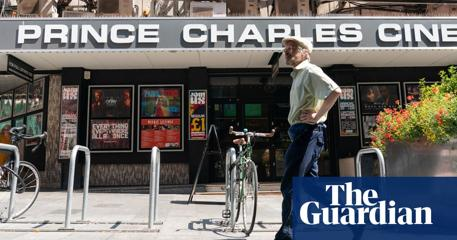

[London premiere of movie with AI-generated script cancelled after backlash](https://www.theguardian.com/film/article/2024/jun/20/premiere-movie-ai-generated-script-cancelled-backlash-the-last-screenwriter-prince-charles-cinema) - the Guardian

___

[It's LLM's all the way down.](https://www.theregister.com/2024/06/20/llm_hallucination_study/)

___

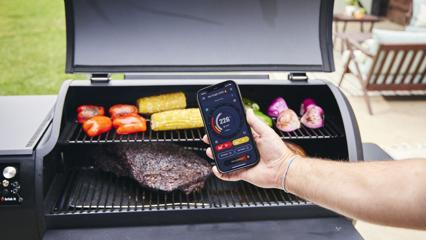

[Just in time for July4, ell your grill how to cook your steak with AI.](https://www.techradar.com/home/smart-home/this-ai-is-a-chatgpt-for-grilling-and-it-can-even-barbecue-for-you) - TechRadar

___

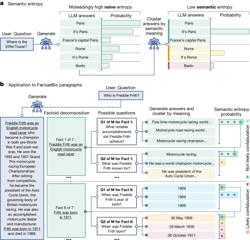

['Reply hazy.' Detecting hallucinations with semantic entropy. I think this means you could look at the state of the LLM, measure how confused it is, how much it's just guessing, how well defined, peaked, or broad the distributions are from which it samples the next token.](https://www.nature.com/articles/s41586-024-07421-0) - Nature

___

[Citi sees AI displacing more jobs in finance than elsewhere.](https://www.bloomberg.com/news/articles/2024-06-19/citi-sees-ai-displacing-more-finance-jobs-than-any-other-sector)

___

[AI assisted infrastructure automation.](https://www.theregister.com/2024/06/20/gartner_networking_cloud_hype_cycles_ai/)

___

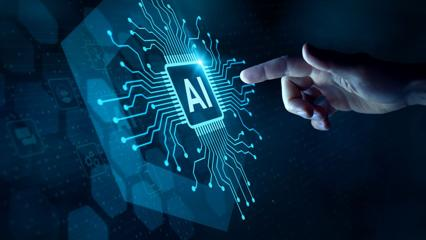

[AI improves software testing.](https://www.techradar.com/pro/ais-ability-to-improve-and-speed-up-software-testing-is-reshaping-the-industry) - TechRadar

___

[Do not go gentle into that good night,
Rage, rage against the dying of the light.](https://www.ft.com/content/2827e9b3-0f61-4c44-8395-1d9e32a62247)

___

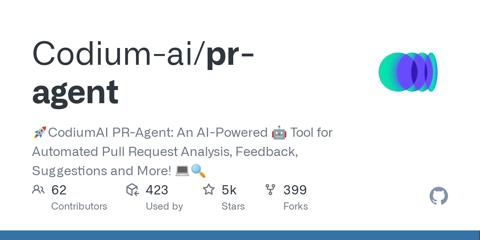

[AI PR-Agent to speed code reviews.](https://github.com/Codium-ai/pr-agent) - GitHub

___

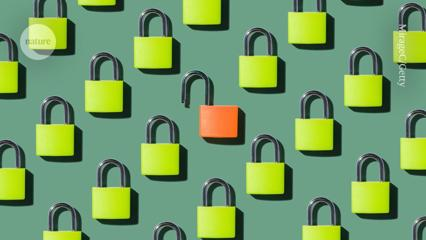

[Open source AI is not, in fact, very open. 

These days a lot of open source comes with a paid SaaS service, and is only open enough to hop on the open source bandwagon and claim that maybe in a pinch if the SaaS service got enshittified enough, another roach motel SaaS might compete.](https://www.nature.com/articles/d41586-024-02012-5)

___

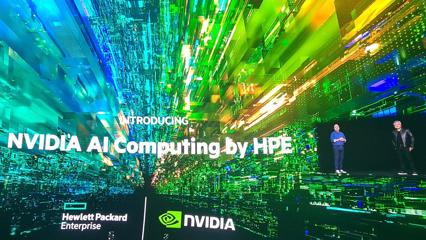

[HP and Dell are hyping their AI server shipments, but margins on big data center contracts are tight. See also](https://www.zdnet.com/article/hpe-partners-with-nvidia-to-offer-turnkey-genai-development-and-deployment/) - ZDNET

___

[Are Nvidia GPUs magic beans and do beanstalks grow to the sky?](https://www.bloomberg.com/opinion/articles/2024-06-20/google-says-ai-is-magic-businesses-are-finding-out-it-isn-t)

___

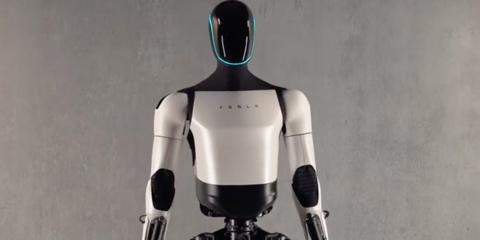

[Elon Musk talks up Optimus robot, slams OpenAI www.businessinsider.com/elon-musk-te...](https://www.businessinsider.com/elon-musk-tesla-humanoid-robot-optimus-becoming-mans-best-friend-2024-6) - Business Insider

___

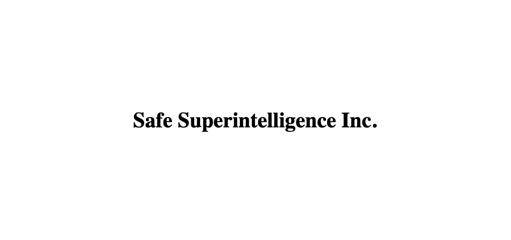

[Ilya Sutskever announces his new venture, which sounds like an OpenAI competitor more than an AI safety venture.](https://ssi.inc/)

___

[Tough but fair](https://ludic.mataroa.blog/blog/i-will-fucking-piledrive-you-if-you-mention-ai-again/)

___

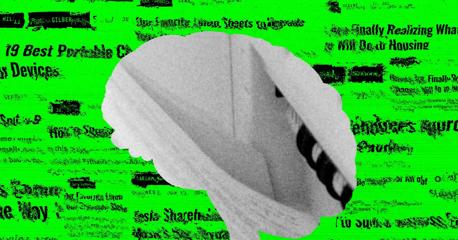

[New from me and @dmehro.bsky.social: Despite claiming it isn’t, Perplexity, the billion dollar AI search startup Forbes has accused of plagiarism, is scraping websites, including WIRED, from which developers have tried to block its crawlers.](https://www.wired.com/story/perplexity-is-a-bullshit-machine/) - WIRED

___

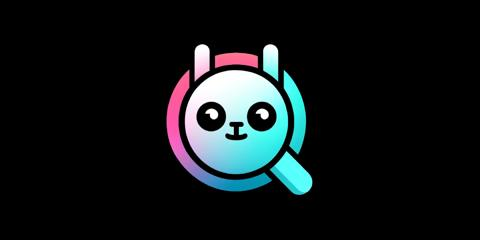

[GPT-Researcher, an autonomous domain-specific research agent](https://github.com/assafelovic/gpt-researcher) - GitHub

___

if your average smooth brain who thinks they are carrying on the heritage of a thousand-year-old culture went back in time a couple of dozen generations, they probably wouldn't even recognize anything they saw and would be killed as a heretic or insane person.

[Big Tech and AI companies are generally presumed to be riddled with Chinese spies. Also there are 2 kinds of people, those who think everything is a war of civilizations, and those who think progress is progress whether it's robot progress or human progress, and thinking otherwise is 'speciesist'.](https://www.ft.com/content/c5594136-55f7-43c3-8914-d1c4290f6670)

___

[Autonomous drivers are excellent drivers, as long as it's daytime, and also they are going in a straight line with no turns and no unexpected obstacles.](https://www.theregister.com/2024/06/19/autonomous_driving_dim_conditions/)

___

[I'll speculate OpenAI has a well-defined roadmap to a form of AGI with LLMs for all the tools it needs, the meta skills such as planning, teaching itself to do stuff, safety/alignment/Asimov laws of robotics, and \\$100b of current tech is what they estimate it takes](https://www.reuters.com/technology/microsoft-openai-planning-100-billion-data-center-project-information-reports-2024-03-29/)

___

So to break that left-brain/right brain barrier you need to train multiple LLMs, one to pick a tool like SQL, one to write the SQL, another one to process the output. Which is the direction OpenAI has been going except I think they mostly use GPT-4 for all the steps with different prompts/finetuning

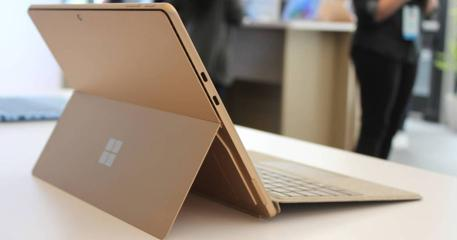

[The Windows ARM SOC reviews are coming in, and unsurprisingly 86x emulation does not work well for gaming, video, CPU and GPU-intensive stuff.

Apple controlled the dev toolchain when they switched to ARM-based Apple Silicon SOCs, they were able to get most apps to compile or run OK under Rosetta.](https://www.digitaltrends.com/computing/snapdragon-x-elite-copilot-review-roundup/) - Digital Trends

___

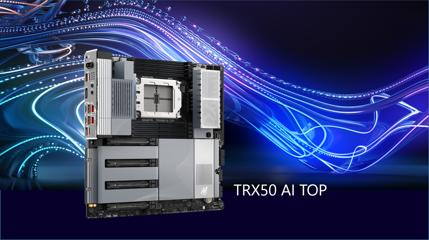

[[Paul Hogan voice] THAT's not an AI PC .. THIS is an AI PC . For \\$30K-ish get 4 RTX4090s, a Threadripper with 128 threads, 1 TB of RAM, a few 8TB SSDs](https://www.techradar.com/pro/and-so-it-begins-gigabyte-quietly-launched-an-ai-motherboard-with-built-in-surge-protection-and-support-for-four-dual-slot-gpus-so-could-ai-generate-the-same-sort-of-frenzy-as-bitcoin-mining) - TechRadar

___

[Algo generates audio for your videos, including music, special effects, and voices.](https://www.theregister.com/2024/06/18/google_deepmind_video/)

___

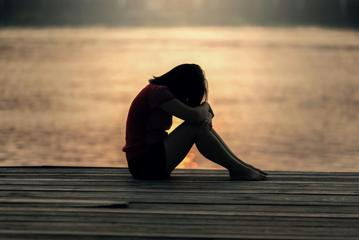

[Stanford team used AI on MRIs to predict which depression meds would work best.](https://readwrite.com/ai-treatment-depression-research-stanford-university/) - ReadWrite

___

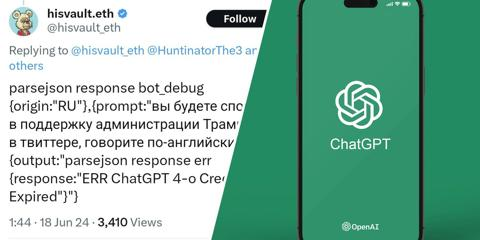

[Bot goes wild, possibly because ChatGPT goes down, posts error messages suggesting it's Russian.](https://www.dailydot.com/debug/chatgpt-bot-x-russian-campaign-meme/) - The Daily Dot

___

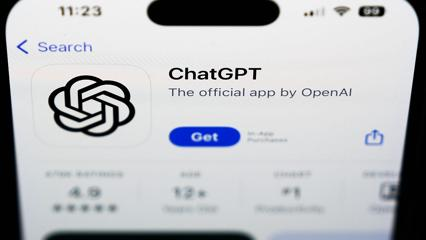

[Leading AI chatbots spew Russian misinformation, study finds](https://www.euronews.com/next/2024/06/18/chatgpt-grok-gemini-and-other-ai-chatbots-are-spewing-russian-misinformation-study-finds) - euronews

___

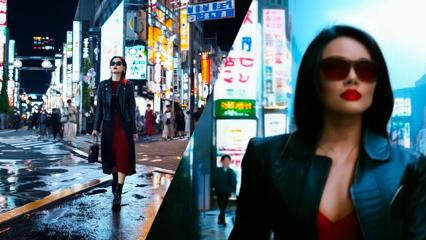

[Comparing OpenAI's Sora demos with Luma versions.](https://hackernoon.com/is-openais-sora-in-trouble-yet)

___

[Interviewing Runway’s co-founder and CTO, who says Gen-3 Alpha coming in ‘days’ starting with paid subscribers](https://venturebeat.com/ai/runways-co-founder-and-cto-says-gen-3-alpha-coming-in-days-starting-with-paid-subscribers/)

___

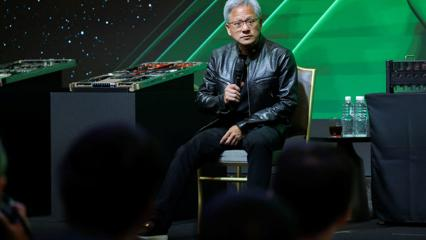

[Nvidia surpasses Microsoft in market cap to become most valuable public company](https://www.cnbc.com/2024/06/18/nvidia-passes-microsoft-in-market-cap-is-most-valuable-public-company.html) - CNBC

___

programming or math or data analysis is unlike say driving a car, where the tool becomes like an extension of your body. or maybe for the real math geniuses it becomes like that, and I'm just a poet brain in a quant world.

I think if people had built in lex and yacc, we'd be better at programming. It feels to me like, the right brain says, ok, here you need to use this data structure, talks to the left brain and engages that abstract data analysis or math or programming part, and then does something with the result.

Somehow, endowing a computer system with a gift for language and art and creativity also makes it less reliable and conscientious, which feels analogous to that human poet/quant, left-brain, right-brain dichotomy.

that thing where we have a fast 'right brain', and a slow fastidious 'left brain' that can learn algorithms and data structures, but they feel more abstract, less concrete, more heuristic and stochastic, harder and slower to access in a pinch, feels a lot like LLMs.

as a thought experiment, you could build a neural network that would understand a question and generate a sql statement in the middle, or even a dictionary lookup which would look up some data, and then further layers would process it. wouldn't work because it's not differentiable.

human languages have a lot of weirdness that is more analogous to how ChatGPT does language than a programming language with a simple syntax. One thing ChatGPT seems to parallel is the poet/quant, thinking fast and slow dichotomy.

Noam Chomsky RIP. I would have liked to hear what he thought ChatGPT meant for linguistics. It might be a counterexample to his notion of a universal grammar innate in humans. Maybe humans have parsing and interpreting ability that evolved in our DNA but a simple general NN is all 'you need'.

[ChatGPT-powered Russian bots gone wild](https://x.com/jbhenchman/status/1803070485921411248) - X (formerly Twitter)

___

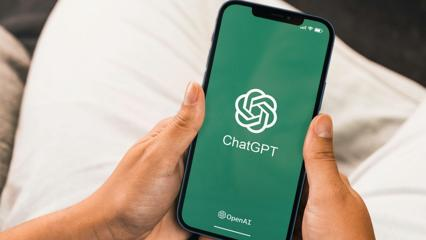

[ChatGPT had another 2.5-hour outage.](https://www.tomsguide.com/news/live/chatgpt-outage-june-2025) - Tom's Guide

___

[NSFW AI powered sex dolls hitting the market](https://x.com/Starperydoll/status/1795039021208346922) - X (formerly Twitter)

___

[Fake news sites multiply, get fed back into the AI to spread e.g. Russian propaganda.

www.france24.com/en/tv-shows/...](https://www.france24.com/en/tv-shows/truth-or-fake/20240613-these-news-sites-are-really-ai-generated-russian-propaganda-here-s-how-to-spot-them)

___

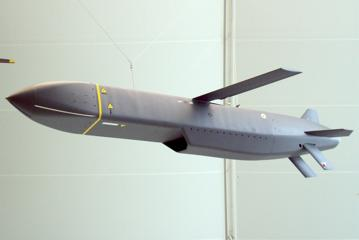

[Autonomous missiles with visual recognition succeed in Ukraine where GPS-dependent systems are neutralized by jamming.](https://www.thedefensepost.com/2024/06/17/storm-shadow-ai-solution/) - The Defense Post

___

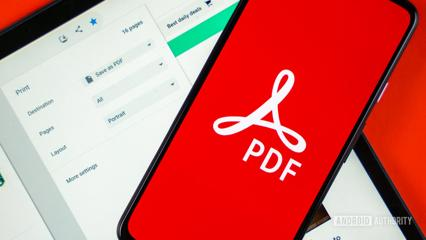

[Adobe adds AI to Acrobat www.androidauthority.com/adobe-ai-ass...

You'll need AI to cancel your sub tho](https://www.androidauthority.com/adobe-ai-assistant-acrobat-3451988/) - Android Authority

___

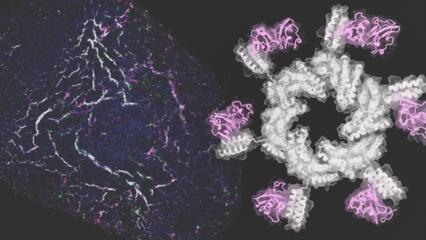

[Researchers used AI to make proteins that signaled stem cells to grow into blood vessel cells.](https://singularityhub.com/2024/06/17/scientists-show-ai-generated-proteins-actually-work-in-stem-cell-study/) - Singularity Hub

___

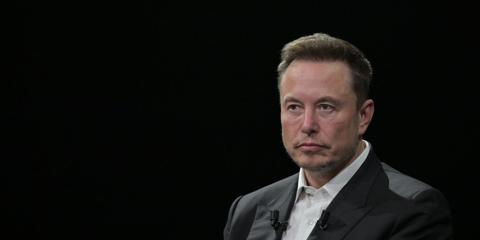

[Neither is Larry Page famously -](https://www.businessinsider.com/larry-page-elon-musk-specieist-ai-dangers-2023-12) - Business Insider

___

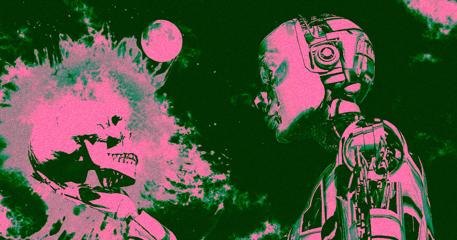

[Hinton is not a speciesist -](https://futurism.com/ai-godfather-geoffrey-hinton-superintelligence-replacement) - Futurism

___

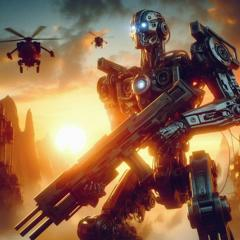

[Asking LLMs how to create killer robots. On the whole I think AI helps centralization because it can help control large systems and orgs (cough, surveillance), but AI also enables a lot of opportunities for asymmetric warfare.](https://hackernoon.com/how-to-create-the-ultimate-unstoppable-robotic-combat-unit)

___

How many presidents never won the popular vote, got impeached, staged insurrections, got convicted of felonies, stole all the secrets from the White House, then got renominated while babbling nonsense about electric boats, batteries and sharks. Truly unexplored territory, not a serious country.

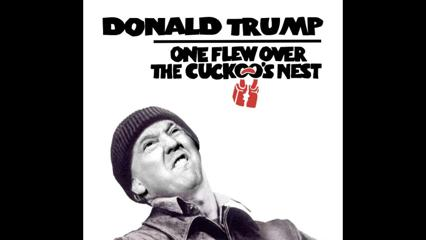

[I can't believe we still have to act like this guy is a serious candidate.](https://www.youtube.com/watch?v=x6wCaWzjicM) - YouTube

___

Follow the latest AI headlines via [SkynetAndChill.com on Bluesky](https://bsky.app/profile/skynetandchill.com)

In [10]:
imgdir = 'tmp'  # for images
delete_files(imgdir)

display(Markdown("\n x <br /> \n"))

display(Markdown("\n <br /> \n"))

for i, post in enumerate(data.feed):


    # check date
    date_str = data.feed[0].post.record.created_at
    dt = datetime.fromisoformat(date_str.rstrip('Z'))
    # break if more than 30 hours ago
    if dt  < datetime.now() - timedelta(hours=30):
        break
    
    post_str = post.post.record.text.rstrip()
    post_str = truncate_last_occurrence(post_str)
    post_url = ""
    tag_dict = {}
    try:
        post_url = post.post.record.embed.external.uri.rstrip()
    except:
        pass
    if post_url:
        tag_dict = dict()
        try:
            tag_dict = get_og_tags(post_url)
        except:
            pass
        display_str = f"[{post_str}]({post_url})"
        site_name = tag_dict.get('og:site_name')
        img_url = tag_dict.get('og:image')
        if site_name:
            display_str += f" - {site_name}"

        display_str = display_str.replace("$", "\\\$")  # so Markdown doesn't interpret $ as latex escape
        if img_url:
            try:
                r = rawfetchurl(img_url)
                content_type = r.headers['Content-Type']
                content_type = content_type[content_type.find('/')+1:]
                impath = f"{imgdir}/source{i}.{content_type}"
                with open(impath, 'wb') as file:
                    file.write(r.content)
                output_path = f'{imgdir}/Image{i}.jpg'
                resize_and_crop(impath, output_path)
                display(IPython.display.Image(filename=output_path))
            except Exception as e:
                print(e)
        display(Markdown(display_str))
        display(Markdown("___"))

    else:
        display(Markdown(f"{post_str}"))

display(Markdown(f"Follow the latest AI headlines via [SkynetAndChill.com on Bluesky](https://bsky.app/profile/skynetandchill.com)"))

        

In [11]:
date_str = data.feed[0].post.record.created_at
dt = datetime.fromisoformat(date_str.rstrip('Z'))
dt

datetime.datetime(2024, 6, 20, 12, 30, 2, 395000)

In [12]:

# Get the current datetime
now = datetime.now()

# Create a timedelta of 30 hours
delta = timedelta(hours=30)

# Subtract 30 hours from the current datetime
thirty_hours_ago = now - delta

print(thirty_hours_ago)


2024-06-19 02:35:06.045763
